In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.3.0


In [ ]:
# By the way, what is a server / service / API?

# Best way to learn is by example
# Here is a service that simply returns your IP address in a JSON

import requests
r = requests.get('https://api.ipify.org?format=json')
j = r.json()
print(j)

# Our Tensorflow model server is the same, except what it does is much more
# complex - it returns the predictions from a ML model!

{'ip': '35.224.223.54'}


In [ ]:
# More imports
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [ ]:
# Load in the data
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [ ]:
# the data is only 2D!
# convolution expects height x width x color
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [ ]:
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656

In [ ]:
# Compile and fit
# Note: make sure you are using the GPU for this!
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

W0810 04:12:02.177557 140535052928896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 13s 211us/sample - loss: 0.5198 - accuracy: 0.8071 - val_loss: 0.3919 - val_accuracy: 0.8524
Epoch 2/15
60000/60000 [==============================] - 9s 153us/sample - loss: 0.3541 - accuracy: 0.8675 - val_loss: 0.3549 - val_accuracy: 0.8657
Epoch 3/15
60000/60000 [==============================] - 9s 152us/sample - loss: 0.3042 - accuracy: 0.8855 - val_loss: 0.3162 - val_accuracy: 0.8874
Epoch 4/15
60000/60000 [==============================] - 9s 152us/sample - loss: 0.2730 - accuracy: 0.8980 - val_loss: 0.2973 - val_accuracy: 0.8944
Epoch 5/15
60000/60000 [==============================] - 9s 153us/sample - loss: 0.2498 - accuracy: 0.9059 - val_loss: 0.3015 - val_accuracy: 0.8904
Epoch 6/15
60000/60000 [==============================] - 9s 153us/sample - loss: 0.2255 - accuracy: 0.9146 - val_loss: 0.2890 - val_accuracy: 0.8939
Epoch 7/15
60000/60000 [=========================

In [ ]:
# Save the model to a temporary directory
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1


Saved model:
total 144
drwxr-xr-x 2 root root   4096 Aug 10 04:14 assets
-rw-r--r-- 1 root root 136883 Aug 10 04:14 saved_model.pb
drwxr-xr-x 2 root root   4096 Aug 10 04:14 variables


In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  10819      0 --:--:-- --:--:-- --:--:-- 10819
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:8 https://deve

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 47 not upgraded.
Need to get 151 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 1.14.0 [151 MB]
Fetched 151 MB in 2s (81.4 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_1.14.0_all.deb ...
Unpacking tensorflow-model-server (1.14.0) ...
Setting up tensorflow-model-server (1.14.0) ...


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

2019-08-10 04:14:43.484998: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-08-10 04:14:43.486899: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-08-10 04:14:43.502478: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-08-10 04:14:43.544172: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:151] Running initialization op on SavedModel bundle at path: /tmp/1
2019-08-10 04:14:43.552722: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 69454 microseconds.
2019-08-10 04:14:43.552775: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:103] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2019-08-10 04:14:43.552887: I tensorflow_

In [ ]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

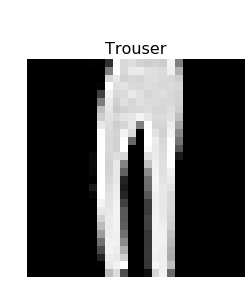

In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

i = np.random.randint(0, len(x_test))
show(i, labels[y_test[i]])

In [ ]:
# Format some data to pass to the server
# {
#   "signature_name": "serving_default",
#   "instances": [ an N x H x W x C list ],
# }

import json
data = json.dumps({"signature_name": "serving_default", "instances": x_test[0:3].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

In [ ]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
j = r.json()
print(j.keys())
print(j)

dict_keys(['predictions'])
{'predictions': [[8.25938809e-16, 2.94385077e-17, 9.78797075e-16, 2.2219498e-16, 2.59219783e-13, 1.91701793e-10, 1.40012654e-16, 6.76713e-11, 7.24115397e-18, 1.0], [1.04329297e-06, 1.63656903e-12, 0.999997139, 7.85040505e-11, 1.13352101e-08, 2.28772096e-14, 1.75158141e-06, 4.41351522e-19, 1.66081106e-15, 2.36975185e-17], [2.25010535e-13, 1.0, 4.64146882e-14, 5.00870963e-17, 6.15678637e-14, 4.10723891e-21, 2.84594985e-18, 1.07107688e-30, 1.73393987e-22, 6.02925506e-22]]}


In [ ]:
# It looks like a 2-D array, let's check its shape
pred = np.array(j['predictions'])
print(pred.shape)

# This is the N x K output array from the model
# pred[n,k] is the probability that we believe the nth sample belongs to the kth class

(3, 10)


In [ ]:
# Get the predicted classes
pred = pred.argmax(axis=1)

In [ ]:
# Map them back to strings
pred = [labels[i] for i in pred]
print(pred)

['Ankle boot', 'Pullover', 'Trouser']


In [ ]:
# Get the true labels
actual = [labels[i] for i in y_test[:3]]
print(actual)

['Ankle boot', 'Pullover', 'Trouser']


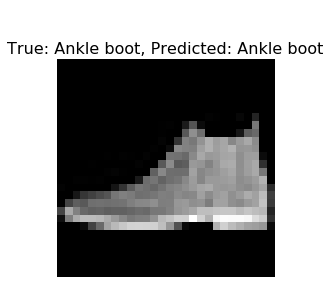

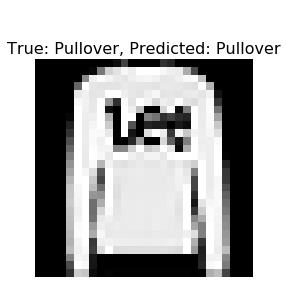

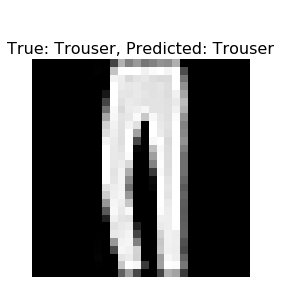

In [ ]:
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

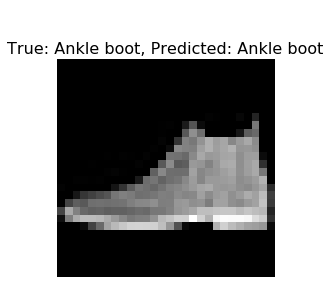

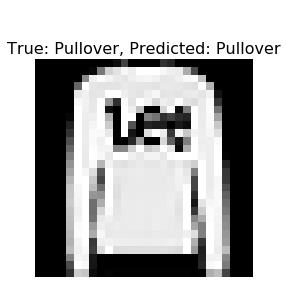

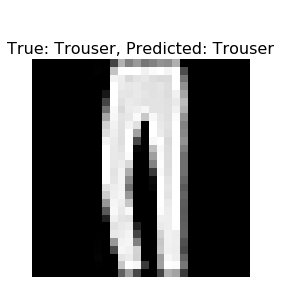

In [ ]:
# Allows you to select a model by version

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [ ]:
# Let's make a new model version
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Flatten()(x)
x = Dense(K, activation='softmax')(x)

model2 = Model(i, x)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and fit
# Note: make sure you are using the GPU for this!
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 5s 86us/sample - loss: 0.4692 - accuracy: 0.8346 - val_loss: 0.3850 - val_accuracy: 0.8629
Epoch 2/15
60000/60000 [==============================] - 5s 80us/sample - loss: 0.3368 - accuracy: 0.8807 - val_loss: 0.3679 - val_accuracy: 0.8678
Epoch 3/15
60000/60000 [==============================] - 5s 80us/sample - loss: 0.3004 - accuracy: 0.8919 - val_loss: 0.3298 - val_accuracy: 0.8799
Epoch 4/15
60000/60000 [==============================] - 5s 80us/sample - loss: 0.2762 - accuracy: 0.9006 - val_loss: 0.3151 - val_accuracy: 0.8866
Epoch 5/15
60000/60000 [==============================] - 5s 82us/sample - loss: 0.2587 - accuracy: 0.9067 - val_loss: 0.3167 - val_accuracy: 0.8877
Epoch 6/15
60000/60000 [==============================] - 5s 80us/sample - loss: 0.2443 - accuracy: 0.9115 - val_loss: 0.3120 - val_accuracy: 0.8881
Epoch 7/15
60000/60000 [==============================] 

In [ ]:
# Save version 2 of the model

version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model2, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/2


Saved model:
total 76
drwxr-xr-x 2 root root  4096 Aug 10 04:34 assets
-rw-r--r-- 1 root root 66590 Aug 10 04:34 saved_model.pb
drwxr-xr-x 2 root root  4096 Aug 10 04:34 variables


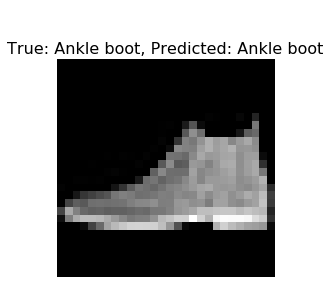

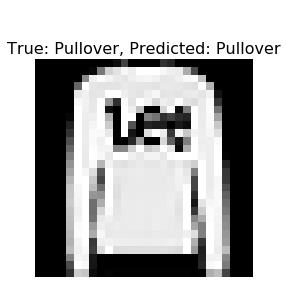

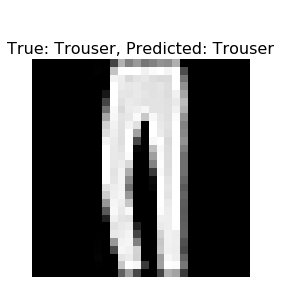

In [ ]:
# Will Tensorflow serving know about the new model without restarting?

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [ ]:
# What if we use a version number that does not exist?
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/3:predict', data=data, headers=headers)
j = r.json()
print(j)

{'error': 'Servable not found for request: Specific(fashion_model, 3)'}
